# NLP: Análisis de Sentimientos con VADER y RoBERTa
Análisis aplicado a descripciones de libros en español.

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings("ignore")

In [2]:
# Cargar datos
file_path = "../data/processed/books.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace(".", "_").str.replace(":", "")
df = df[["blurb", "tags", "book_title"]].dropna(subset=["blurb"]).head(500)
df.head()

,blurb,tags,book_title
0,"Walter Ciszek, jesuita norteamericano, entró e...","abandonment-in-god, biography, catholic, chełm...",Caminando por valles oscuros: Memorias de un j...
1,<p>A chance encounter with a reproduction of R...,"_pilar, _sindy, abandonment-in-god, anxiety, a...",The Return of the Prodigal Son: A Story of Hom...
2,"A pesar de nuestros mejores esfuerzos, muchos ...","catholic, chełmińska, christ, christianity, de...",Liberado: Una Guía Práctica para la Liberación
3,Esta breve obra se compone de cartas escritas ...,"abandonment-in-god, catholic, christ, classics...",El Abandono en la Divina Providencia: Clásicos...
4,Resulta difícil no emocionarse varias veces al...,"adventures, atheism, biography, catholic, chur...",Una familia de bandidos en 1793


## Preprocesamiento NLP: Tokenización con NLTK

In [3]:
import nltk
from nltk.tokenize import PunktSentenceTokenizer, TreebankWordTokenizer
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
tokenizer_sent = PunktSentenceTokenizer()
tokenizer_words = TreebankWordTokenizer()
example = df["blurb"].iloc[65]
sentences = tokenizer_sent.tokenize(example)
tokens = []
for sentence in sentences:
    tokens.extend(tokenizer_words.tokenize(sentence))
print(tokens)
print(nltk.pos_tag(tokens))

['St', 'John', 'of', 'the', 'Cross', 'testifies', 'to', 'a', 'God', 'who', 'longs', 'to', 'meet', 'us', 'in', 'our', 'deepest', 'need', '.', 'Whilst', 'rejection', 'and', 'imprisonment', 'played', 'their', 'part', 'in', 'the', 'life', 'of', 'this', 'sixteenth-century', 'Spanish', 'friar', ',', 'John', "'s", 'poetry', 'and', 'prose', 'reveal', 'the', 'beauty', 'and', 'power', 'of', 'a', 'wondrous', 'God', '.', 'It', 'gives', 'us', 'courage', 'to', 'believe', 'in', 'the', 'possibility', 'of', 'change', 'in', 'our', 'own', 'lives', ',', 'however', 'unlikely', 'or', 'impossible', 'this', 'may', 'seem.', '<', 'br', '/', '>', 'Father', 'Iain', 'Matthew', 'uses', 'this', 'classic', 'inspirational', 'Christian', 'writing', 'as', 'his', 'starting', 'point', ',', 'and', 'offers', 'five', 'interpretations', 'which', 'make', 'its', 'richness', 'relevant', 'to', 'the', 'modern', 'reader', '.']
[('St', 'NNP'), ('John', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('Cross', 'NNP'), ('testifies', 'NNS'), ('to

## Análisis de Sentimientos con VADER

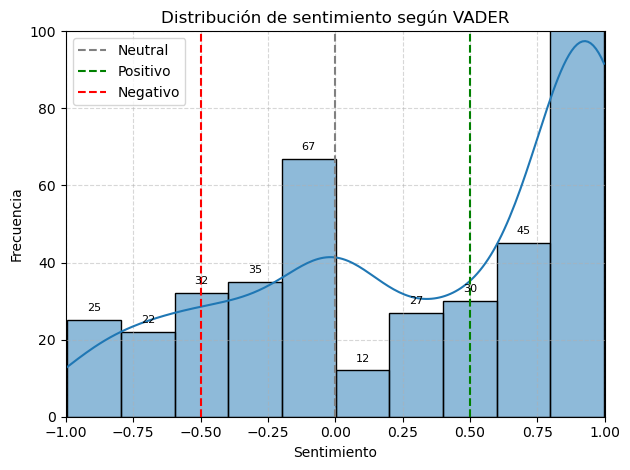

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
pol_scores = {}
for i, row in df.iterrows():
    text = row["blurb"]
    scores = sia.polarity_scores(text)
    pol_scores[i] = scores
vaders = pd.DataFrame(pol_scores).T
vaders = pd.concat([df.reset_index(drop=True), vaders.reset_index(drop=True)], axis=1)
sns.histplot(vaders["compound"], kde=True)
plt.title("Distribución de sentimiento según VADER")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlabel("Sentimiento")
plt.ylabel("Frecuencia")
plt.xticks(rotation=0)
plt.xlim(-1, 1)
plt.ylim(0, 100)
plt.axvline(x=0, color="gray", linestyle="--", label="Neutral")
plt.axvline(x=0.5, color="green", linestyle="--", label="Positivo")
plt.axvline(x=-0.5, color="red", linestyle="--", label="Negativo")
plt.legend()
plt.tight_layout()

# Show values over the bars
for p in plt.gca().patches:
    plt.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="bottom", fontsize=8, color="black", rotation=0,
                 xytext=(0, 5), textcoords="offset points")
plt.savefig("../img/roberta_vader_distribution.jpg", dpi=300, bbox_inches="tight")
plt.show()

## Análisis de Sentimientos con RoBERTa (inglés)

In [6]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
MODEL = "j-hartmann/emotion-english-distilroberta-base"
classifier = pipeline("text-classification", model=MODEL, return_all_scores=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Device set to use cpu


In [7]:
def mooder(text):
    max_len = 512
    encoded = tokenizer(text, return_tensors="pt", max_length=max_len, truncation=True, padding="max_length")
    with torch.no_grad():
        output = model(**encoded)
    scores = output.logits[0].numpy()
    return {
        "anger": scores[0], "disgust": scores[1], "fear": scores[2],
        "joy": scores[3], "neutral": scores[4], "sadness": scores[5],
        "surprise": scores[6]
    }

In [ ]:
roberta = df["blurb"].apply(mooder)
roberta_df = pd.DataFrame(roberta.tolist())
moods = pd.concat([df.reset_index(drop=True), roberta_df.reset_index(drop=True)], axis=1)
moods.sample(10)

In [ ]:
moods.sort_values(by="joy", ascending=False).head(10)

In [ ]:
sns.histplot(moods["sadness"], kde=True)
plt.title("Distribución de 'sadness' según RoBERTa")
# Grid
plt.grid(visible=True, color="gray", linestyle="--", linewidth=0.5)
plt.axvline(moods["sadness"].mean(), color="red", linestyle="--", linewidth=1, label="Media")
plt.axvline(moods["sadness"].median(), color="blue", linestyle="--", linewidth=1, label="Mediana")
plt.axvline(moods["sadness"].mode()[0], color="green", linestyle="--", linewidth=1, label="Moda")
plt.legend()
plt.xlabel("Puntuación de tristeza")
plt.ylabel("Frecuencia")
plt.title("Distribución de 'sadness' según RoBERTa")
plt.tight_layout()
plt.grid(visible=True, color="gray", linestyle="--", linewidth=0.5)
# Guardar en imagen jpg
plt.savefig("../img/roberta-sadness.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Guardar el modelo y el tokenizer
joblib.dump(model, "../model/sentiment_roberta_model.joblib")
joblib.dump(tokenizer, "../model/sentiment_roberta_tokenizer.joblib")

In [ ]:
# Mejorar la gráfica en barras mostrando los valores encima de cada barra con separación vertical

sentiment_colors = { 
    "anger": "#b71c1c",  # Rojo muy oscuro (máx. negatividad)
    "disgust": "#d32f2f",  # Rojo oscuro
    "fear": "#ef5350",  # Rojo algo más claro
    "sadness": "#ffcdd2",  # Tono salmón muy claro
    "neutral": "#f0f0f0",  # Gris muy claro (punto de transición)
    "surprise": "#ffe082",  # Amarillo pastel
    "joy": "#ffd600"  # Amarillo vivo (máx. positividad)
}

# Calcular los valores promedio de las emociones
emotion_means = moods.iloc[:, 3:10].mean()

# Crear la gráfica
ax = emotion_means.plot(
    kind="bar", 
    color=sentiment_colors.values(), 
    figsize=(10, 6)
)

# Añadir valores encima de cada barra con separación vertical
for i, value in enumerate(emotion_means):
    ax.text(i, value + 0.03, f"{value:.2f}", ha="center", fontsize=10)  # Separación ajustada con +0.03

# Configurar título, etiquetas y diseño
plt.title("Distribución de emociones según RoBERTa")
plt.xlabel("Emociones")
plt.ylabel("Puntuación media")
plt.xticks(rotation=0)
plt.grid(visible=True, color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Guardar la gráfica como imagen
plt.savefig("../img/roberta-emotions.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Calcular los valores promedio de las emociones
emotion_means = moods.iloc[:, 3:10].mean()

# Mostrar los valores promedio
print(emotion_means)